In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import joblib
from joblib import parallel_backend
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np


In [2]:

# Mount drive and read dataset
from google.colab import drive
drive.mount('/content/drive')
#MergeddatasetAphaventures.csv')

df = pd.read_csv('/content/drive/My Drive/OUTPUT_CSV/MergeddatasetAphaventures.csv')
df.isna().any()

# Encode categorical variables
le_city = LabelEncoder()
le_company = LabelEncoder()

df['City_encoded'] = le_city.fit_transform(df['City'])
df['Company_encoded'] = le_company.fit_transform(df['Company'])
df['Holiday_Indicator_encoded'] = df['Holiday_Indicator']

# Derived Features
df['Holiday_Weekend'] = df['Holiday_Indicator_encoded'] * df['Weekend']
df['City_KM'] = df['City_encoded'] * df['KM_Travelled']

# Encode Income_Class
income_class_encoder = LabelEncoder()
df['Income_Class_encoded'] = income_class_encoder.fit_transform(df['Income_Class'])

# Map Income_Class_encoded to median values
income_mapping = {0: 8781.0, 1: 19994.0, 2: 30011.0}
df['Income_Value'] = df['Income_Class_encoded'].map(income_mapping)

# Select features for modeling
features = [
    'KM_Travelled',
    'City_encoded',
    'Company_encoded',
    'Holiday_Indicator_encoded',
    'Weekend',
    'Holiday_Weekend',
    'City_KM'
]

target = 'Price_Charged'



Mounted at /content/drive


In [3]:
df.columns

Index(['Transaction_ID', 'Date_of_Travel', 'Company', 'City', 'KM_Travelled',
       'Price_Charged', 'Cost_of_Trip', 'Travel_Date', 'Year', 'Month', 'Day',
       'Day_of_week', 'Day_of_week_name', 'Weekend', 'Customer_ID',
       'Payment_Mode', 'Gender', 'Age', 'Income', 'Population', 'Users',
       'Holiday', 'Holiday_Indicator', 'Profit', 'Profit_Percentage',
       'Age_range', 'Income_Class', 'City_encoded', 'Company_encoded',
       'Holiday_Indicator_encoded', 'Holiday_Weekend', 'City_KM',
       'Income_Class_encoded', 'Income_Value'],
      dtype='object')

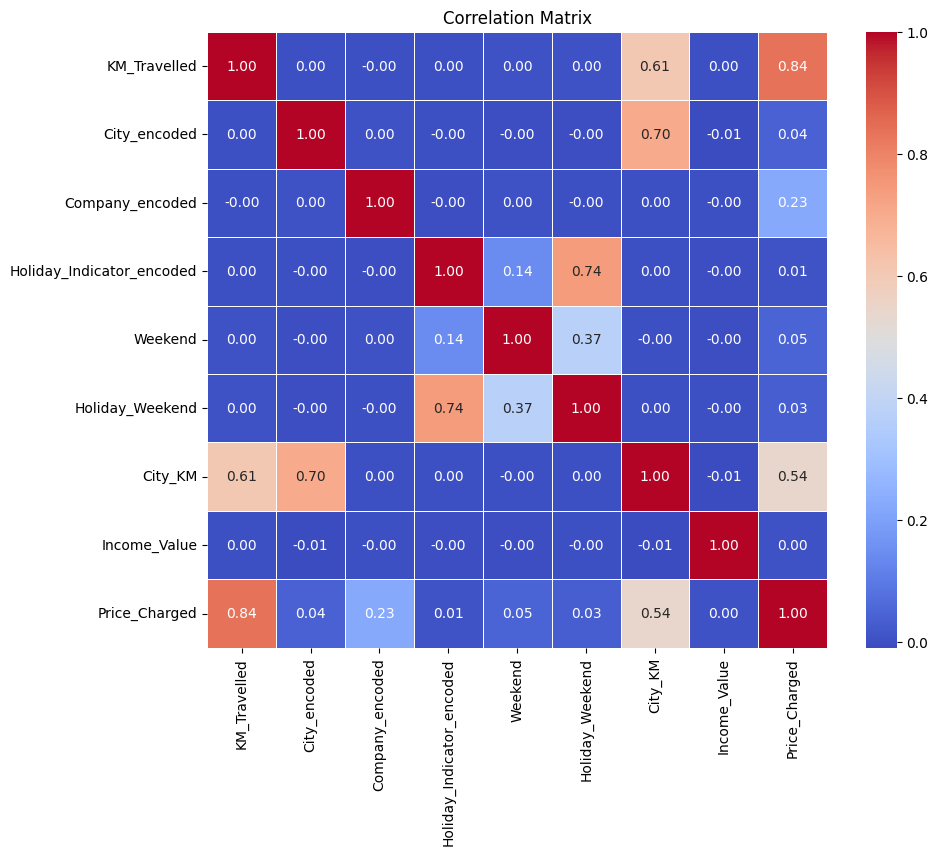

In [4]:
data = df[['KM_Travelled',
    'City_encoded',
    'Company_encoded',
    'Holiday_Indicator_encoded',
    'Weekend',
    'Holiday_Weekend',
    'City_KM',
    'Income_Value',
    'Price_Charged']]
numerical_features = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# stratification

In [5]:
#Prepare data

X = df[features]
y = df[target]

stratify_feature = df['City_encoded']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=stratify_feature  #  stratification
)


# Train models
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression())]),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
}

# Model Evaluation Function
def evaluate_regression_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    # Cross-validation scores
    v_scores = cross_val_score(model, X_train, y_train, cv=5)
    scores_mean = v_scores.mean()
    scores_std = v_scores.std()

    # Print performance metrics
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")

    # Return model evaluation results
    return model_name, mse, mae, rmse, r2, mape, scores_mean, scores_std


In [6]:
# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    result = evaluate_regression_model(model, X_test, y_test, name)
    results.append(result)

# Display results
results_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "RMSE", "R²", "MAPE",'Accuracy','Standard Deviation'])
print("\nModel Comparison:")
print(results_df)



Linear Regression Performance:
MSE: 18618.8278, MAE: 99.2006, RMSE: 136.4508, R²: 0.7549, MAPE: 0.3200

Polynomial Regression Performance:
MSE: 11888.2029, MAE: 74.0783, RMSE: 109.0330, R²: 0.8435, MAPE: 0.1828

Ridge Regression Performance:
MSE: 18618.8267, MAE: 99.2004, RMSE: 136.4508, R²: 0.7549, MAPE: 0.3200

Lasso Regression Performance:
MSE: 18646.8672, MAE: 98.8535, RMSE: 136.5535, R²: 0.7545, MAPE: 0.3138

Random Forest Regressor Performance:
MSE: 7167.3349, MAE: 55.5208, RMSE: 84.6601, R²: 0.9056, MAPE: 0.1325

Decision Tree Regressor Performance:
MSE: 7621.0513, MAE: 56.5229, RMSE: 87.2986, R²: 0.8997, MAPE: 0.1352

Model Comparison:
                     Model           MSE        MAE        RMSE        R²  \
0        Linear Regression  18618.827794  99.200611  136.450826  0.754891   
1    Polynomial Regression  11888.202883  74.078340  109.033036  0.843497   
2         Ridge Regression  18618.826668  99.200423  136.450821  0.754891   
3         Lasso Regression  18646.86718

# Hyperparameter tuning using RandomizedSearchCV

In [7]:

# Hyperparameter tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=8,  # Number of random samples
    cv=3,
    scoring='r2',
    n_jobs=4,
    verbose=1
)

with parallel_backend('threading', n_jobs=2):  # Use threading instead of loky
    random_search.fit(X_train, y_train)

# Best parameters and best score
print("\nBest Parameters for Random Forest Regressor:")
print(random_search.best_params_)
print(f"Best R² Score: {random_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_rf_model = random_search.best_estimator_
best_rf_result = evaluate_regression_model(best_rf_model, X_test, y_test, "Tuned Random Forest Regressor")



Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best Parameters for Random Forest Regressor:
{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10}
Best R² Score: 0.9116

Tuned Random Forest Regressor Performance:
MSE: 6757.8931, MAE: 54.6626, RMSE: 82.2064, R²: 0.9110, MAPE: 0.1312


In [8]:
import joblib
# Save the best trained model to a file
joblib.dump(best_rf_model, 'HyperTunedRFR.pkl')
print("Model saved successfully!")

Model saved successfully!


In [9]:
# Append results to the comparison DataFrame
results.append(best_rf_result)
results_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "RMSE", "R²", "MAPE",'Accuracy','Standard Deviation'])

# Display updated results
print("\nUpdated Model Comparison:")
print(results_df)


Updated Model Comparison:
                           Model           MSE        MAE        RMSE  \
0              Linear Regression  18618.827794  99.200611  136.450826   
1          Polynomial Regression  11888.202883  74.078340  109.033036   
2               Ridge Regression  18618.826668  99.200423  136.450821   
3               Lasso Regression  18646.867185  98.853506  136.553532   
4        Random Forest Regressor   7167.334923  55.520760   84.660114   
5        Decision Tree Regressor   7621.051325  56.522879   87.298633   
6  Tuned Random Forest Regressor   6757.893134  54.662627   82.206406   

         R²      MAPE  CV_SCORE_MEAN  Standard Deviation  
0  0.754891  0.320003       0.754494            0.001969  
1  0.843497  0.182790       0.843985            0.001764  
2  0.754891  0.320000       0.754494            0.001969  
3  0.754521  0.313772       0.754051            0.002017  
4  0.905645  0.132492       0.904999            0.000798  
5  0.899672  0.135222       0.8980

# Profit or Loss Prediction

In [10]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, f1_score


In [38]:
# Select features for modeling
features_profit = [
    'KM_Travelled',
    'City_encoded',
    'Company_encoded',
    'Holiday_Indicator_encoded',
    'Weekend',
    'Holiday_Weekend',
    'City_KM',
    'Income_Value'
]

# profit prediction
target_regression = 'Profit'

# Prepare data
X_profit = df[features_profit]
y_profit = df[target_regression]

# Train-test split for regression
X_train_profit, X_test_profit, y_train_profit, y_test_profit = train_test_split(X_profit, y_profit, test_size=0.2, random_state=42)

# Train and evaluate each model for Profit Prediction
results_regression = []
for name, model in models.items():
    model.fit(X_train_profit, y_train_profit)
    result = evaluate_regression_model(model, X_test_profit, y_test_profit, name)
    results_regression.append(result)

# Display regression results
results_regression_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "RMSE", "R²", "MAPE",'Accuracy','Standard Deviation'])
print("\nRegression Model Comparison:")
print(results_regression_df)


ProfitRandomRegressor Model saved successfully.

Linear Regression Performance:
MSE: 18165.9988, MAE: 96.4124, RMSE: 134.7813, R²: 0.2905, MAPE: 9307257443693.7695

Polynomial Regression Performance:
MSE: 12129.0801, MAE: 75.2237, RMSE: 110.1321, R²: 0.5263, MAPE: 12345475971414.3262

Ridge Regression Performance:
MSE: 18165.9989, MAE: 96.4123, RMSE: 134.7813, R²: 0.2905, MAPE: 9307406927583.5215

Lasso Regression Performance:
MSE: 18196.4068, MAE: 96.1094, RMSE: 134.8941, R²: 0.2894, MAPE: 9786425360909.5371

Random Forest Regressor Performance:
MSE: 7667.5903, MAE: 57.9953, RMSE: 87.5648, R²: 0.7005, MAPE: 10673032010604.6172

Decision Tree Regressor Performance:
MSE: 8519.7930, MAE: 60.1832, RMSE: 92.3027, R²: 0.6673, MAPE: 5412644459087.8643

Regression Model Comparison:
                           Model           MSE        MAE        RMSE  \
0              Linear Regression  18618.827794  99.200611  136.450826   
1          Polynomial Regression  11888.202883  74.078340  109.03303

In [13]:
# Save the best-performing model
import joblib

best_rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

best_rf_regressor.fit(X_train_profit, y_train_profit)

joblib.dump(best_rf_model, 'ProfitRandomRegressor.pkl')

print("ProfitRandomRegressor Model saved successfully.")


ProfitRandomRegressor Model saved successfully.


# Classification of Profitable vs Non-Profitable Trips

In [15]:
  # Convert Profit into a binary classification target (1 = Profitable, 0 = Non-Profitable)
  df['Profitable'] = (df['Profit'] > 0).astype(int)  # Profitable if profit > 0

  # Prepare data
  X_profit = df[features_profit]
  y_classification = df['Profitable']
  # Train-test split for classification
  X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_profit, y_classification, test_size=0.2, random_state=42)

  # Define classification models
  classification_models = {
      "Random Forest Classifier": RandomForestClassifier(random_state=42),
      "Decision Tree Classifier": DecisionTreeClassifier(random_state=42)
  }

  # Model Evaluation Function for Classification
  def evaluate_classification_model(model, X_test, y_test, model_name="Model"):
      y_pred = model.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)

      # Print classification metrics
      print(f"\n{model_name} Classification Performance:")
      print(f"Accuracy: {accuracy:.4f}")
      print(f"Precision: {precision:.4f}")
      print(f"Recall: {recall:.4f}")
      print(f"F1-Score: {f1:.4f}")

      # Return classification metrics
      return model_name, accuracy, precision, recall, f1

  # Train and evaluate each model for Profitable vs Non-Profitable Classification
  results_classification = []
  for name, model in classification_models.items():
      model.fit(X_train_class, y_train_class)
      result = evaluate_classification_model(model, X_test_class, y_test_class, name)
      results_classification.append(result)

  # Display classification results
  results_classification_df = pd.DataFrame(results_classification, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
  print("\nClassification Model Comparison:")
  print(results_classification_df)


Random Forest Classifier Classification Performance:
Accuracy: 0.9245
Precision: 0.9371
Recall: 0.9851
F1-Score: 0.9605

Decision Tree Classifier Classification Performance:
Accuracy: 0.9179
Precision: 0.9383
Recall: 0.9761
F1-Score: 0.9568

Classification Model Comparison:
                      Model  Accuracy  Precision    Recall  F1-Score
0  Random Forest Classifier  0.924535   0.937100  0.985077  0.960489
1  Decision Tree Classifier  0.917903   0.938267  0.976053  0.956787


In [51]:
import joblib

best_classifier = RandomForestClassifier(random_state=42)

best_classifier.fit(X_train_class, y_train_class)

joblib.dump(best_classifier, 'ProfitRandomClassifier.pkl')

print("ProfitRandomClassifier Model saved successfully.")


ProfitRandomClassifier Model saved successfully.


In [16]:
print("City Encoding Mapping:")
city_mapping = {index: city for index, city in enumerate(le_city.classes_)}
for encoded_value, city_name in city_mapping.items():
        print(f"{encoded_value}: {city_name}")

City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC


In [19]:
import pandas as pd
import joblib

# Load the trained models
loaded_model=joblib.load('HyperTunedRFR.pkl')


# Income class mapping (for profit prediction)
income_mapping = {
    0: 8781.0,  # Lower class
    1: 19994.0,  # Middle class
    2: 30011.0,  # Upper class
}

# Function to get user input and predict profit or classification (Profitable vs Non-Profitable)
def predict_trip_price():
    print("Enter the following details:")

    # Collect user inputs
    KM_Travelled = float(input("Enter distance travelled (KM): "))
    print("City Encoding Mapping:")
    city_mapping = {index: city for index, city in enumerate(le_city.classes_)}
    for encoded_value, city_name in city_mapping.items():
            print(f"{encoded_value}: {city_name}")
    City_encoded = int(input("Enter city code (e.g., 0 for City A, 1 for City B): "))
    Company_encoded = int(input("Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): "))
    Holiday_Indicator_encoded = int(input("Is it a holiday? (0 for No, 1 for Yes): "))
    Weekend = int(input("Is it a weekend? (0 for No, 1 for Yes): "))
    '''
    # Take income class as numeric input (0, 1, or 2)
    try:
        Income_Class_encoded = int(input("Enter income class (0 for Lower class, 1 for Middle class, 2 for Upper class): ").strip())
        if Income_Class_encoded not in [0, 1, 2]:
            raise ValueError("Income class must be 0, 1, or 2.")
    except ValueError as e:
        print(f"Error: {e}. Make sure the income class is one of [0, 1, 2].")
        return

    # Map the encoded income class to its corresponding income value
    Income_Value = income_mapping.get(Income_Class_encoded, None)
    if Income_Value is None:
        print("Error: Invalid income class encoded value!")
        return
'''
    # Derived features
    Holiday_Weekend = Holiday_Indicator_encoded * Weekend
    City_KM = City_encoded * KM_Travelled

    # Create a DataFrame for the input data
    input_data = pd.DataFrame({
        'KM_Travelled': [KM_Travelled],
        'City_encoded': [City_encoded],
        'Company_encoded': [Company_encoded],
        'Holiday_Indicator_encoded': [Holiday_Indicator_encoded],
        'Weekend': [Weekend],
        'Holiday_Weekend': [Holiday_Weekend],
        'City_KM': [City_KM]
    })

    # Predict the Profit (Regression model)
    predicted_price = loaded_model.predict(input_data)
    print(f"\nPredicted Price: {predicted_price[0]:.2f}")

# Call the prediction function
predict_trip_price()


Enter the following details:
Enter distance travelled (KM): 25
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 1
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 0
Is it a holiday? (0 for No, 1 for Yes): 0
Is it a weekend? (0 for No, 1 for Yes): 0

Predicted Price: 365.96


In [20]:
predict_trip_price()


Enter the following details:
Enter distance travelled (KM): 25
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 1
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 0
Is it a holiday? (0 for No, 1 for Yes): 1
Is it a weekend? (0 for No, 1 for Yes): 0

Predicted Price: 372.30


In [21]:
predict_trip_price()

Enter the following details:
Enter distance travelled (KM): 25
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 1
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 0
Is it a holiday? (0 for No, 1 for Yes): 1
Is it a weekend? (0 for No, 1 for Yes): 1

Predicted Price: 400.56


In [22]:
predict_trip_price()

Enter the following details:
Enter distance travelled (KM): 25
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 1
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 1
Is it a holiday? (0 for No, 1 for Yes): 0
Is it a weekend? (0 for No, 1 for Yes): 0

Predicted Price: 476.36


In [23]:
predict_trip_price()


Enter the following details:
Enter distance travelled (KM): 25
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 1
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 1
Is it a holiday? (0 for No, 1 for Yes): 1
Is it a weekend? (0 for No, 1 for Yes): 0

Predicted Price: 475.45


In [24]:
predict_trip_price()


Enter the following details:
Enter distance travelled (KM): 25
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 1
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 1
Is it a holiday? (0 for No, 1 for Yes): 1
Is it a weekend? (0 for No, 1 for Yes): 1

Predicted Price: 494.44


In [25]:
predict_trip_price()


Enter the following details:
Enter distance travelled (KM): 10
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 0
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 0
Is it a holiday? (0 for No, 1 for Yes): 0
Is it a weekend? (0 for No, 1 for Yes): 0

Predicted Price: 134.00


In [40]:
import pandas as pd
import joblib

# Load the trained models
loaded_model_PROFIT = joblib.load('ProfitRandomRegressor.pkl')
loaded_model_price = joblib.load('HyperTunedRFR.pkl')

# Income class mapping (for profit prediction)
income_mapping = {
    0: 8781.0,  # Lower class
    1: 19994.0,  # Middle class
    2: 30011.0,  # Upper class
}

# Function to get user input and predict profit or classification (Profitable vs Non-Profitable)
def predict_trip_price():
    print("Enter the following details:")

    # Collect user inputs
    KM_Travelled = float(input("Enter distance travelled (KM): "))
    print("City Encoding Mapping:")
    city_mapping = {index: city for index, city in enumerate(le_city.classes_)}
    for encoded_value, city_name in city_mapping.items():
        print(f"{encoded_value}: {city_name}")
    City_encoded = int(input("Enter city code (e.g., 0 for City A, 1 for City B): "))
    Company_encoded = int(input("Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): "))
    Holiday_Indicator_encoded = int(input("Is it a holiday? (0 for No, 1 for Yes): "))
    Weekend = int(input("Is it a weekend? (0 for No, 1 for Yes): "))

    # Take income class as numeric input (0, 1, or 2)
    try:
        Income_Class_encoded = int(input("Enter income class (0 for Lower class, 1 for Middle class, 2 for Upper class): ").strip())
        if Income_Class_encoded not in [0, 1, 2]:
            raise ValueError("Income class must be 0, 1, or 2.")
    except ValueError as e:
        print(f"Error: {e}. Make sure the income class is one of [0, 1, 2].")
        return

    # Map the encoded income class to its corresponding income value
    Income_Value = income_mapping.get(Income_Class_encoded, None)
    if Income_Value is None:
        print("Error: Invalid income class encoded value!")
        return

    # Derived features
    Holiday_Weekend = Holiday_Indicator_encoded * Weekend
    City_KM = City_encoded * KM_Travelled

    # Prepare input data for price prediction (exclude Income_Value for price)
    input_data_price = pd.DataFrame({
        'KM_Travelled': [KM_Travelled],
        'City_encoded': [City_encoded],
        'Company_encoded': [Company_encoded],
        'Holiday_Indicator_encoded': [Holiday_Indicator_encoded],
        'Weekend': [Weekend],
        'Holiday_Weekend': [Holiday_Weekend],
        'City_KM': [City_KM]
    })

    # Prepare input data for profit prediction (include Income_Value for profit)
    input_data = pd.DataFrame({
        'KM_Travelled': [KM_Travelled],
        'City_encoded': [City_encoded],
        'Company_encoded': [Company_encoded],
        'Holiday_Indicator_encoded': [Holiday_Indicator_encoded],
        'Weekend': [Weekend],
        'Holiday_Weekend': [Holiday_Weekend],
        'City_KM': [City_KM],
        'Income_Value': [Income_Value]  # Include Income_Value for profit prediction
    })

    # Predict the Price (Regression model)
    predicted_price = loaded_model_price.predict(input_data_price)
    print(f"\nPredicted Price: {predicted_price[0]:.2f}")

    # Predict the Profit (Regression model)
    predicted_profit = loaded_model_PROFIT.predict(input_data)
    print(f"\nPredicted Profit: {predicted_profit[0]:.2f}")

# Call the prediction function
predict_trip_price()


Enter the following details:
Enter distance travelled (KM): 20
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 1
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 0
Is it a holiday? (0 for No, 1 for Yes): 0
Is it a weekend? (0 for No, 1 for Yes): 0
Enter income class (0 for Lower class, 1 for Middle class, 2 for Upper class): 0

Predicted Price: 292.49

Predicted Profit: 85.68


In [53]:
import pandas as pd
import joblib

# Load the trained models
loaded_model_PROFIT = joblib.load('ProfitRandomRegressor.pkl')
loaded_model_price = joblib.load('HyperTunedRFR.pkl')
loaded_model_class = joblib.load('ProfitRandomClassifier.pkl')

# Income class mapping (for profit prediction)
income_mapping = {
    0: 8781.0,  # Lower class
    1: 19994.0,  # Middle class
    2: 30011.0,  # Upper class
}

# Function to get user input and predict profit or classification (Profitable vs Non-Profitable)
def predict_trip_price():
    print("Enter the following details:")

    # Collect user inputs
    KM_Travelled = float(input("Enter distance travelled (KM): "))
    print("City Encoding Mapping:")
    city_mapping = {index: city for index, city in enumerate(le_city.classes_)}
    for encoded_value, city_name in city_mapping.items():
        print(f"{encoded_value}: {city_name}")
    City_encoded = int(input("Enter city code (e.g., 0 for City A, 1 for City B): "))
    Company_encoded = int(input("Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): "))
    Holiday_Indicator_encoded = int(input("Is it a holiday? (0 for No, 1 for Yes): "))
    Weekend = int(input("Is it a weekend? (0 for No, 1 for Yes): "))

    # Take income class as numeric input (0, 1, or 2)
    try:
        Income_Class_encoded = int(input("Enter income class (0 for Lower class, 1 for Middle class, 2 for Upper class): ").strip())
        if Income_Class_encoded not in [0, 1, 2]:
            raise ValueError("Income class must be 0, 1, or 2.")
    except ValueError as e:
        print(f"Error: {e}. Make sure the income class is one of [0, 1, 2].")
        return

    # Map the encoded income class to its corresponding income value
    Income_Value = income_mapping.get(Income_Class_encoded, None)
    if Income_Value is None:
        print("Error: Invalid income class encoded value!")
        return

    # Derived features
    Holiday_Weekend = Holiday_Indicator_encoded * Weekend
    City_KM = City_encoded * KM_Travelled

    # Prepare input data for price prediction (exclude Income_Value for price)
    input_data_price = pd.DataFrame({
        'KM_Travelled': [KM_Travelled],
        'City_encoded': [City_encoded],
        'Company_encoded': [Company_encoded],
        'Holiday_Indicator_encoded': [Holiday_Indicator_encoded],
        'Weekend': [Weekend],
        'Holiday_Weekend': [Holiday_Weekend],
        'City_KM': [City_KM]
    })

    # Prepare input data for profit prediction (include Income_Value for profit)
    input_data = pd.DataFrame({
        'KM_Travelled': [KM_Travelled],
        'City_encoded': [City_encoded],
        'Company_encoded': [Company_encoded],
        'Holiday_Indicator_encoded': [Holiday_Indicator_encoded],
        'Weekend': [Weekend],
        'Holiday_Weekend': [Holiday_Weekend],
        'City_KM': [City_KM],
        'Income_Value': [Income_Value]  # Include Income_Value for profit prediction
    })

    # Predict the Price (Regression model)
    predicted_price = loaded_model_price.predict(input_data_price)
    print(f"\nPredicted Price: {predicted_price[0]:.2f}")

    # Predict the Profit (Regression model)
    predicted_profit = loaded_model_PROFIT.predict(input_data)
    print(f"\nPredicted Profit: {predicted_profit[0]:.2f}")

    # Prepare input data for classification (exclude Income_Value for classification)
    input_data_class = input_data.drop(columns=["Income_Value"])

    # Predict the Profitability (classification model)
    predicted_profit_class = loaded_model_class.predict(input_data_class)
    print(f"\nPredicted Profitability: {'Profitable' if predicted_profit_class[0] == 1 else 'Non-Profitable'}")

# Call the prediction function
predict_trip_price()


Enter the following details:
Enter distance travelled (KM): 50
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 9
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 0
Is it a holiday? (0 for No, 1 for Yes): 0
Is it a weekend? (0 for No, 1 for Yes): 1
Enter income class (0 for Lower class, 1 for Middle class, 2 for Upper class): 1

Predicted Price: 801.10

Predicted Profit: 342.70

Predicted Profitability: Profitable


In [54]:
predict_trip_price()


Enter the following details:
Enter distance travelled (KM): 5
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 0
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 1
Is it a holiday? (0 for No, 1 for Yes): 0
Is it a weekend? (0 for No, 1 for Yes): 0
Enter income class (0 for Lower class, 1 for Middle class, 2 for Upper class): 0

Predicted Price: 92.70

Predicted Profit: 37.42

Predicted Profitability: Profitable


In [58]:

predict_trip_price()

Enter the following details:
Enter distance travelled (KM): 12
City Encoding Mapping:
0: ATLANTA GA
1: AUSTIN TX
2: BOSTON MA
3: CHICAGO IL
4: DALLAS TX
5: DENVER CO
6: LOS ANGELES CA
7: MIAMI FL
8: NASHVILLE TN
9: NEW YORK NY
10: ORANGE COUNTY
11: PHOENIX AZ
12: PITTSBURGH PA
13: SACRAMENTO CA
14: SAN DIEGO CA
15: SEATTLE WA
16: SILICON VALLEY
17: TUCSON AZ
18: WASHINGTON DC
Enter city code (e.g., 0 for City A, 1 for City B): 5
Enter company code (e.g., 0 for Yellow Cab, 1 for Pink Cab): 0
Is it a holiday? (0 for No, 1 for Yes): 0
Is it a weekend? (0 for No, 1 for Yes): 0
Enter income class (0 for Lower class, 1 for Middle class, 2 for Upper class): 0

Predicted Price: 151.38

Predicted Profit: -0.55

Predicted Profitability: Non-Profitable
